# Practical 3: Markov Decision Processes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Markov Chain

Define a transition matrix

In [2]:
n_states = 10
idx = np.arange(n_states)
transition_matrix = np.zeros((n_states, n_states))
transition_matrix[idx, (idx - 1) % n_states] = 0.1
transition_matrix[idx, (idx + 1) % n_states] = 0.9
transition_matrix[0, 0] = 0.8
transition_matrix[0, 1] = 0.1
transition_matrix[0, -1] = 0.1
print(f"normalised: {np.all(transition_matrix.sum(axis=1)==1)}")

normalised: True


Sample and plot episodes

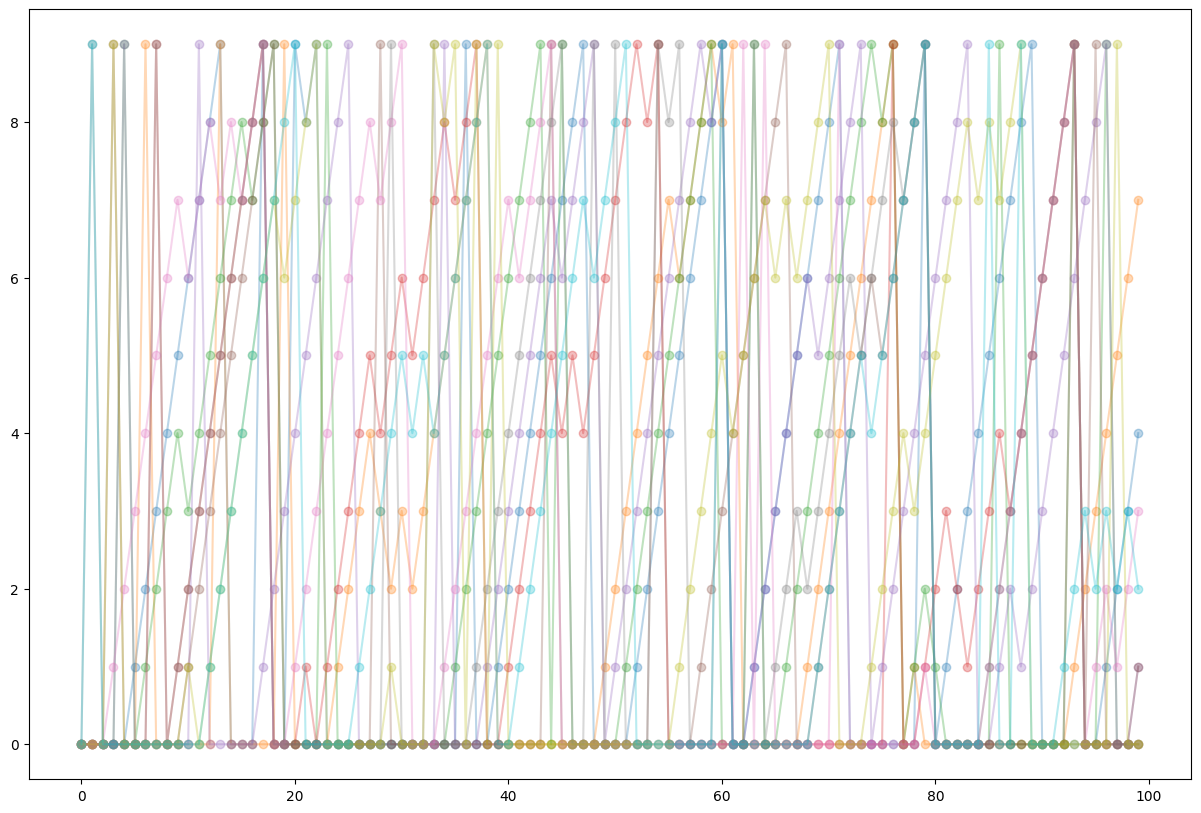

In [3]:
def sample_episodes(n_episodes, length_episodes):
    episodes = np.zeros((n_episodes, length_episodes), dtype=int)
    for idx_episodes in range(n_episodes):
        for idx_time in range(1, length_episodes):
            current_state = episodes[idx_episodes, idx_time - 1]
            probs = transition_matrix[current_state]
            next_state = np.random.choice(n_states, p=probs)
            episodes[idx_episodes, idx_time] = next_state
    return episodes

episodes = sample_episodes(n_episodes=10, length_episodes=100)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(np.arange(episodes.shape[1]), episodes.T, '-o', alpha=0.3);

Plot statistics of state visits

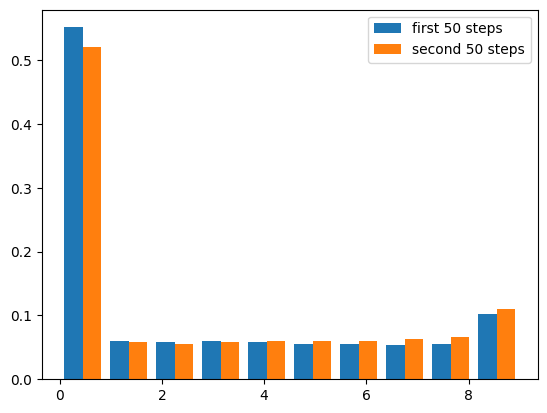

In [4]:
episodes = sample_episodes(n_episodes=100, length_episodes=100)
plt.hist((episodes[:, :50].flatten(), episodes[:, 50:].flatten()),
         density=True,
         label=["first 50 steps", "second 50 steps"])
plt.legend()

Compute the closed-form solution for stationary distribution

In [5]:
eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
stationary = None
for idx in range(n_states):
    if np.isclose(eigvals[idx], 1):
        stationary = eigvecs[:, idx].real
        stationary /= stationary.sum()
print(f"Is stationary: {np.all(np.isclose(stationary @ transition_matrix, stationary))}")
print(stationary)

Is stationary: True
[0.47368421 0.05263158 0.05263159 0.05263167 0.05263237 0.05263871
 0.05269575 0.05320915 0.05782976 0.0994152 ]


## Markov Reward Process

Add a reward function and estimate the expected reward over time

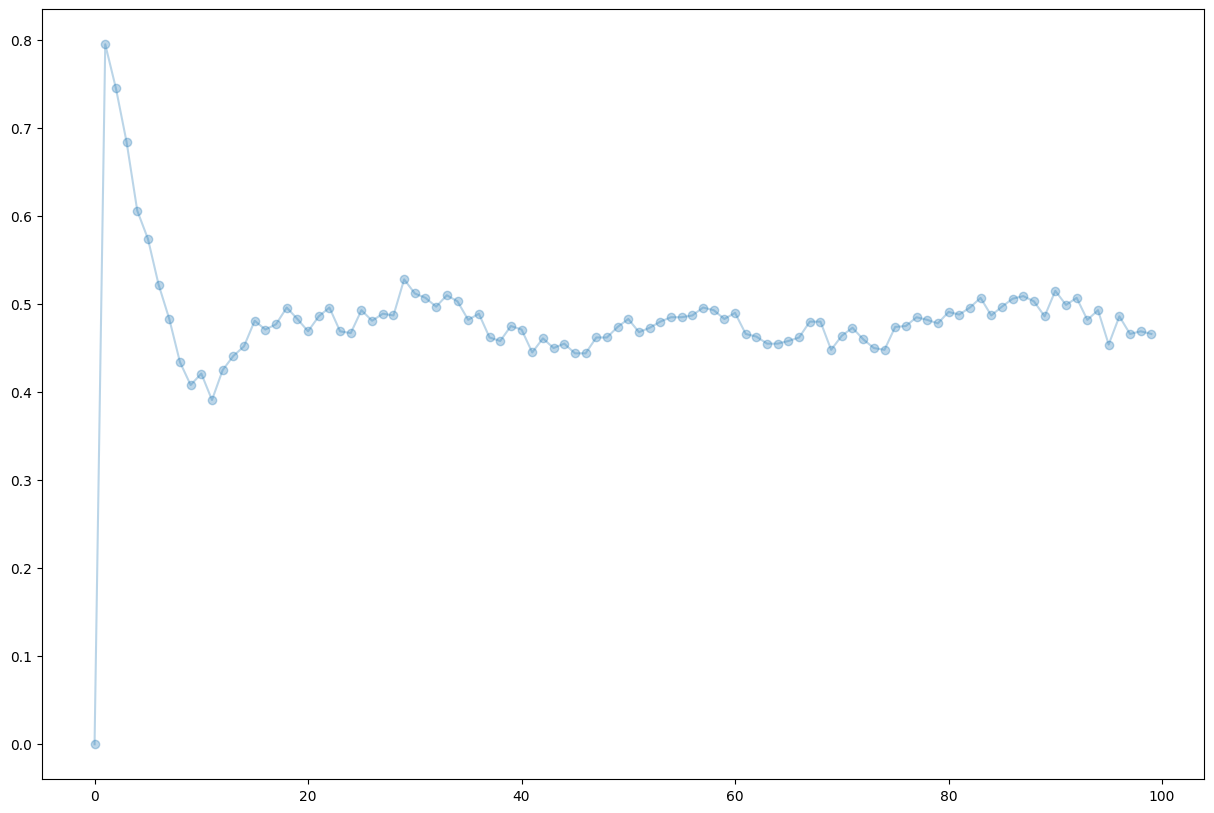

In [6]:
def reward_function(s):
    return int(s == 0)

def sample_episodes(n_episodes, length_episodes):
    episodes = np.zeros((n_episodes, length_episodes, 2), dtype=int)
    for idx_episodes in range(n_episodes):
        for idx_time in range(1, length_episodes):
            current_state = episodes[idx_episodes, idx_time - 1, 0]
            probs = transition_matrix[current_state]
            next_state = np.random.choice(n_states, p=probs)
            episodes[idx_episodes, idx_time, 0] = next_state
            episodes[idx_episodes, idx_time, 1] = reward_function(next_state)
    return episodes

episodes = sample_episodes(n_episodes=1000, length_episodes=100)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(np.arange(episodes.shape[1]), episodes[:, :, 1].mean(axis=0), '-o', alpha=0.3);

Add a discount factor and estimate state values

In [7]:
def sample_episodes(n_episodes, length_episodes, start_state):
    episodes = np.zeros((n_episodes, length_episodes, 2), dtype=int)
    episodes[:, 0, 0] = start_state
    for idx_episodes in range(n_episodes):
        for idx_time in range(1, length_episodes):
            current_state = episodes[idx_episodes, idx_time - 1, 0]
            probs = transition_matrix[current_state]
            next_state = np.random.choice(n_states, p=probs)
            episodes[idx_episodes, idx_time, 0] = next_state
            episodes[idx_episodes, idx_time, 1] = reward_function(next_state)
    return episodes

def estimate_state_values(*, discount, start_state_list, **kwargs):
    state_values = {}
    for start_state in start_state_list:
        episodes = sample_episodes(start_state=start_state, **kwargs)
        discounted_rewards = episodes[:, :, 1] * np.power(discount, np.arange(episodes.shape[1]))
        returns = discounted_rewards.sum(axis=1)
        value = returns.mean()
        state_values[start_state] = value
        print(f"Value for state {start_state}: {value}")
    return state_values

state_values = estimate_state_values(discount=0.5,
                                     start_state_list=[n_states - 1, 0, 1],
                                     n_episodes=100, 
                                     length_episodes=10)

Value for state 9: 0.807109375
Value for state 0: 0.70759765625
Value for state 1: 0.15224609375


Compute the closed-form solution for the state values

In [8]:
R = np.zeros(n_states)
R[0] = 1
np.linalg.solve(np.eye(n_states) - 0.5 * transition_matrix, 0.5 * transition_matrix @ R)

array([0.74105284, 0.09069124, 0.00808578, 0.00789158, 0.01663844,
       0.03609746, 0.07836786, 0.17013997, 0.36938128, 0.80194284])

## MDP

Add action to move up/down and update the transition matrix accordingly

In [9]:
n_actions = 2  # up/down
idx = np.arange(n_states)
transition_matrix = np.zeros((n_states, n_states, n_actions))
transition_matrix[idx, (idx - 1) % n_states, 0] = 0.1
transition_matrix[idx, (idx + 1) % n_states, 0] = 0.9
transition_matrix[idx, (idx - 1) % n_states, 1] = 0.9
transition_matrix[idx, (idx + 1) % n_states, 1] = 0.1
print(f"normalised: {np.all(transition_matrix.sum(axis=1)==1)}")

normalised: True


Adapt your sampling routine

In [10]:
def sample_episodes(n_episodes, length_episodes, start_state, policy):
    episodes = np.zeros((n_episodes, length_episodes, 3), dtype=int)
    episodes[:, 0, 0] = start_state
    for idx_episodes in range(n_episodes):
        for idx_time in range(1, length_episodes):
            current_state = episodes[idx_episodes, idx_time - 1, 0]
            action = np.random.choice(n_actions, p=policy[current_state])
            probs = transition_matrix[current_state, :, action]
            next_state = np.random.choice(n_states, p=probs)
            episodes[idx_episodes, idx_time, 0] = next_state
            episodes[idx_episodes, idx_time, 1] = reward_function(next_state)
            episodes[idx_episodes, idx_time, 2] = action
    return episodes

Define a uniform policy and estimate state values

In [11]:
policy = np.zeros((n_states, n_actions))
policy[:, 0] = 0.5
policy[:, 1] = 0.5

estimate_state_values(discount=0.5,
                      start_state_list=[n_states - 1, 0, 1],
                      n_episodes=100, 
                      length_episodes=10,
                      policy=policy);

Value for state 9: 0.31931640625
Value for state 0: 0.147421875
Value for state 1: 0.30107421875


Change the policy to always go one step up and re-estimate the state values

In [12]:
policy = np.zeros((n_states, n_actions))
policy[:, 0] = 1
policy[:, 1] = 0

estimate_state_values(discount=0.5,
                      start_state_list=[n_states - 1, 0, 1],
                      n_episodes=100, 
                      length_episodes=10,
                      policy=policy);

Value for state 9: 0.4842578125
Value for state 0: 0.0540625
Value for state 1: 0.06353515625


Experiment with different policies and try to improve them

In [13]:
policy = np.zeros((n_states, n_actions))
policy[:int(n_states / 2), 0] = 0
policy[:int(n_states / 2), 1] = 1
policy[int(n_states / 2):, 0] = 1
policy[int(n_states / 2):, 1] = 0

estimate_state_values(discount=0.5,
                      start_state_list=[n_states - 1, 0, 1],
                      n_episodes=100, 
                      length_episodes=10,
                      policy=policy);

Value for state 9: 0.57611328125
Value for state 0: 0.310078125
Value for state 1: 0.5958984375
